In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join("..", "build")))

In [2]:
from cipells.experiments.continuous1d import *

In [3]:
import numpy as np
from matplotlib import pyplot, colors
%matplotlib notebook

In [4]:
pyplot.figure()

In [5]:
positions = [-6.2, 7.4]
fluxes = [2.0, 3.0]

class ArrayPair:
    
    @classmethod
    def fromBounds(cls, x0, x1, **kwds):
        fine = np.linspace(x0 - 0.5, x1 + 0.5, 1 + 20*(x1 - x0))
        pixels = np.arange(x0, x1 + 1, dtype=int)
        return cls(fine=fine, pixels=pixels, **kwds)

    def __init__(self, fine, pixels):
        self.fine = fine
        self.pixels = pixels
        
    @property
    def bounds(self):
        return (self.pixels[0], self.pixels[-1])
        
class InputImage:
    
    def __init__(self, scaling, offset, sky, sigma=None, psf=None):
        self.sky = sky
        self.to_sky = AffineTransform(scaling=scaling, offset=offset)
        self.from_sky = self.to_sky.inverse
        self.frame = ArrayPair.fromBounds(x0=int(np.floor(self.from_sky(float(sky.bounds[0])))),
                                          x1=int(np.ceil(self.from_sky(float(sky.bounds[-1])))))
        if psf is None:
            self.psf = GaussianPixelConvolution(Gaussian(scaling=sigma), Pixel())
        else:
            self.psf = psf
        self.data = ArrayPair(pixels=np.zeros(self.frame.pixels.shape, dtype=float),
                              fine=np.zeros(self.frame.fine.shape, dtype=float))
        for p, f in zip(positions, fluxes):
            self.data.pixels[:] += self.psf(self.frame.pixels - self.from_sky(p))*f
            self.data.fine[:] += self.psf(self.frame.fine - self.from_sky(p))*f
            
    def project(self):
        s = self.psf(np.subtract.outer(self.frame.pixels, self.from_sky(self.sky.pixels)))
        return Accumulation(phi=np.dot(s.transpose(), s), psi=np.dot(self.data.pixels, s))

    def plot(self, title):
        pyplot.figure(title, figsize=(9.6, 6.4))
        pyplot.subplot2grid((4, 9), (0, 0), colspan=9)
        pyplot.plot(self.frame.pixels, self.data.pixels, ".", label='z')
        pyplot.plot(self.frame.fine, self.data.fine, alpha=0.5, label='z (fine)')
        pyplot.xlim(*self.frame.bounds)
        pyplot.ylabel("input data")
        pyplot.subplot2grid((4, 9), (1, 0), colspan=9)
        proj = self.project()
        pyplot.plot(self.sky.pixels, proj.psi, ".", label='psi')
        pyplot.xlim(self.to_sky(self.frame.bounds[0]), self.to_sky(self.frame.bounds[-1]))
        pyplot.ylabel("psi")
        
        norm = colors.SymLogNorm(1E-12, vmin=-1.0, vmax=1.0)
        pyplot.subplot2grid((4, 9), (2, 0), colspan=4, rowspan=2)
        pyplot.imshow(proj.phi, interpolation='nearest', origin='upper', norm=norm)
        pyplot.xlabel("phi")
        pyplot.subplot2grid((4, 9), (2, 4), colspan=4, rowspan=2)
        avg, delta = proj.mean_phi()
        pyplot.imshow(delta, interpolation='nearest', origin='upper', norm=norm)
        pyplot.xlabel("phi - mean(phi)")
        pyplot.colorbar(cax=pyplot.subplot2grid((4, 9), (2, 8), rowspan=2))
        
        pyplot.subplots_adjust(wspace=2.0, hspace=0.5)

class Accumulation:
    
    def __init__(self, phi, psi):
        self.phi = phi
        self.psi = psi

    def mean_phi(self, radius=40):
        n = self.phi.shape[0]
        avg = np.zeros(radius*2 + 1, dtype=float)
        for i in range(radius, n - radius):
            avg += self.phi[i, i - radius:i + radius + 1]
        avg /= (n - 2*radius)
        delta = self.phi.copy()
        for i in range(0, n):
            lo = -radius if i >= radius else -i
            hi = radius + 1 if i < n - radius else n - i
            delta[i, i + lo: i + hi] -= avg[radius + lo: radius + hi]
        return avg, delta
    
    def __iadd__(self, other):
        self.phi += other.phi
        self.psi += other.psi
        return self

In [6]:
sky = ArrayPair.fromBounds(-50, 50)

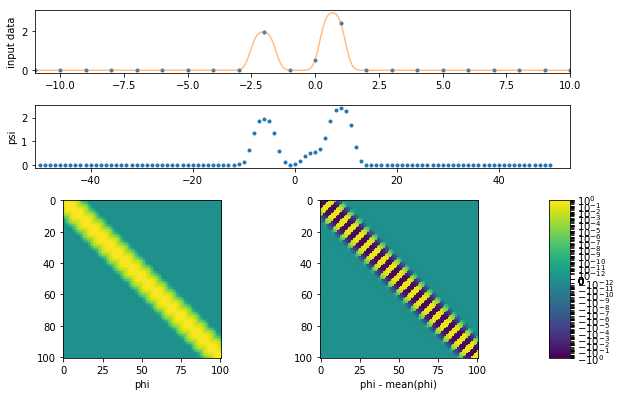

In [15]:
input1 = InputImage(sigma=0.2, scaling=5.0, offset=4.0, sky=sky)
input1.plot("Severely Undersampled")

<IPython.core.display.Javascript object>


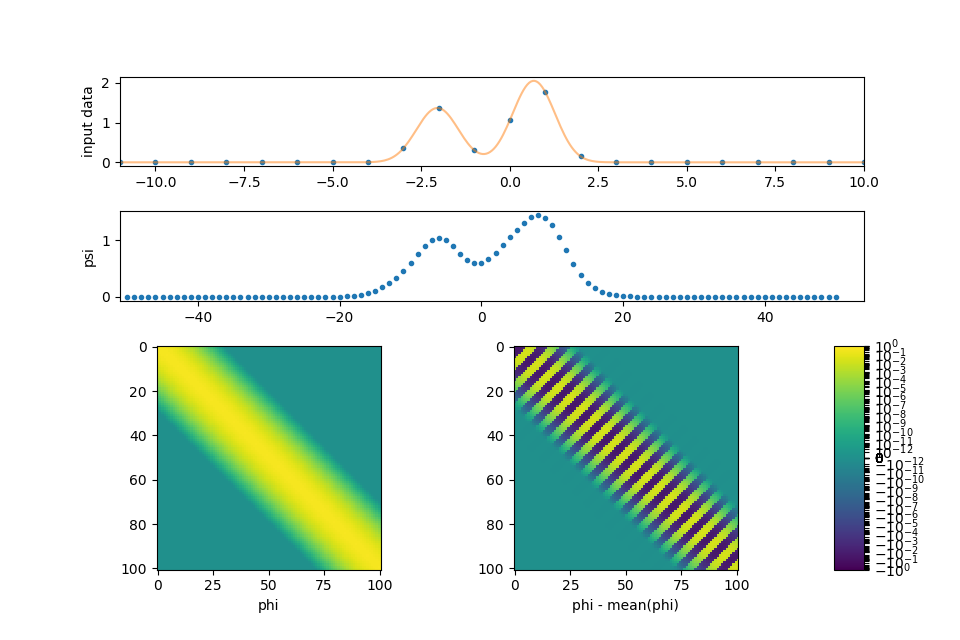

In [11]:
input2 = InputImage(sigma=0.5, scaling=5.0, offset=4.0, sky=sky)
input2.plot("Moderately Undersampled")

<IPython.core.display.Javascript object>


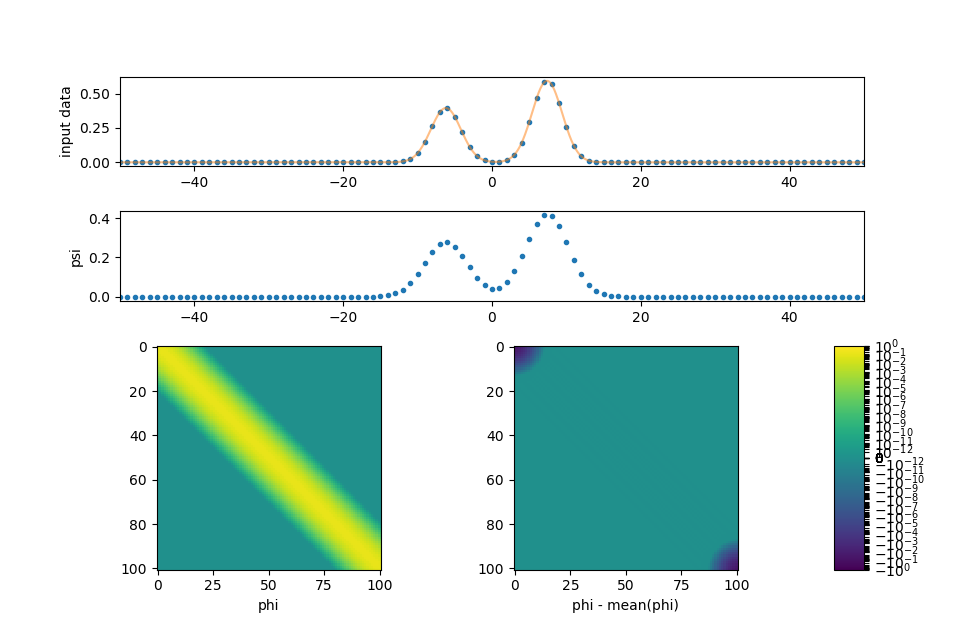

In [12]:
input3 = InputImage(sigma=2.0, scaling=1.0, offset=0.0, sky=sky)
input3.plot("Well-Sampled, No Scaling")

<IPython.core.display.Javascript object>


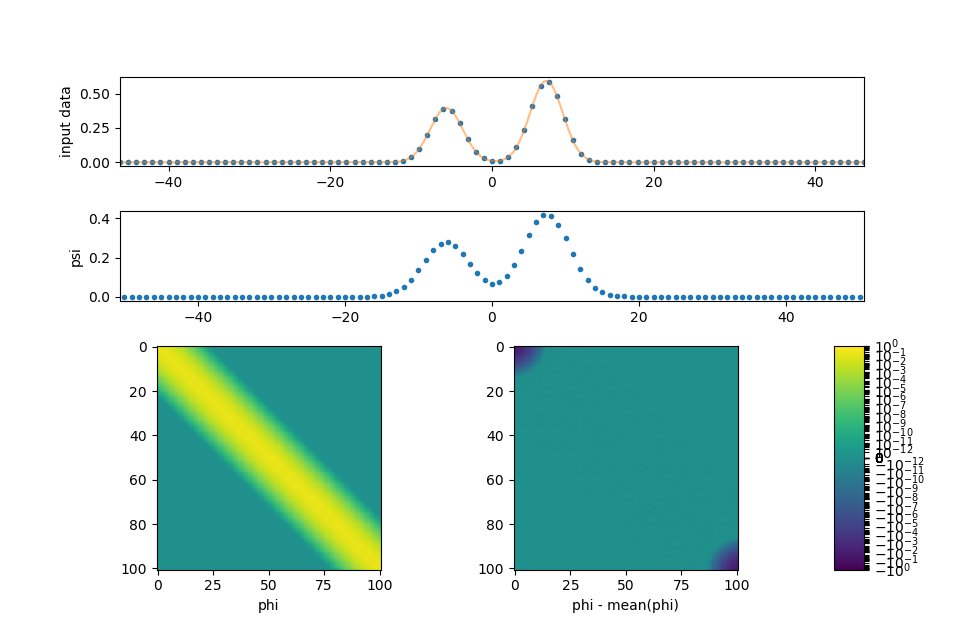

In [167]:
InputImage(sigma=2.0, scaling=1.1, offset=0.0, sky=sky).plot("Well-Sampled, 10% Scaling.")

<IPython.core.display.Javascript object>


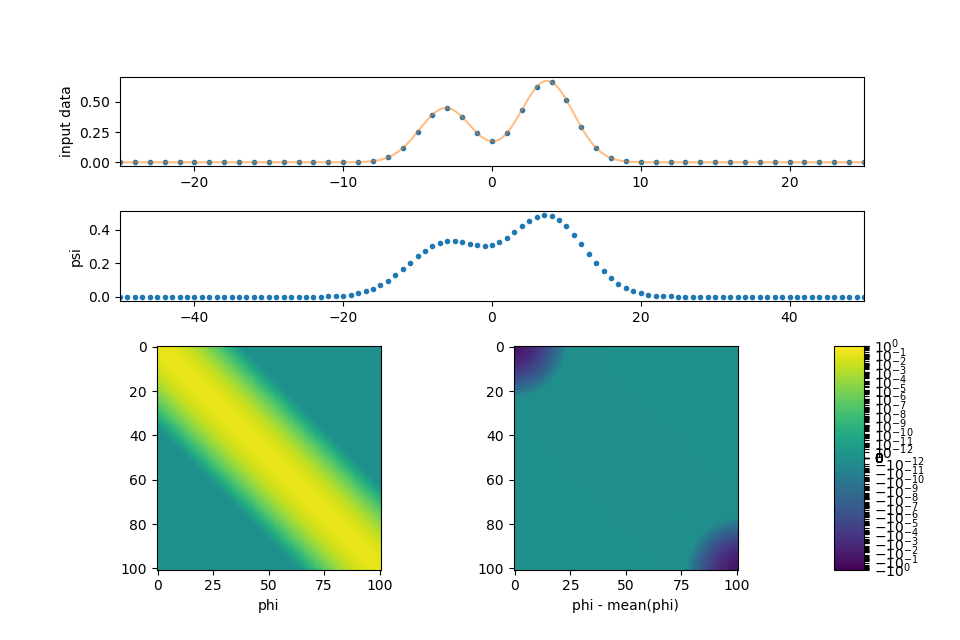

In [168]:
InputImage(sigma=1.75, scaling=2.0, offset=0.0, sky=sky).plot("Well-Sampled, 200% Scaling.")

In [12]:
to_sky = AffineTransform(scaling=0.8, offset=0.0)
from_sky = to_sky.inverse

In [17]:
to_sky.scaling

0.8

In [14]:
scaled = InputImage(sigma=2.5, scaling=0.8, offset=0.0, sky=sky)
aligned = InputImage(psf=scaled.psf.transformedBy(scaled.to_sky), scaling=1.0, offset=0.0, sky=sky)

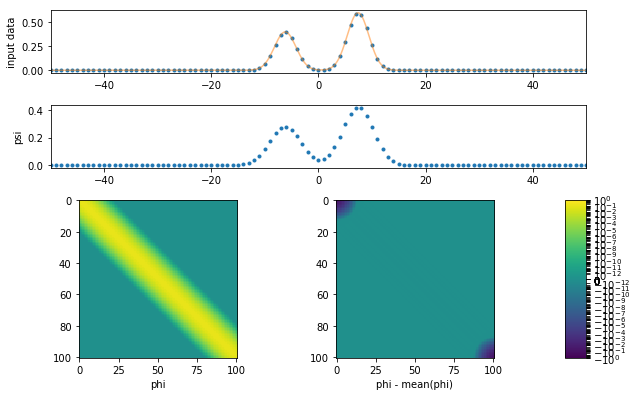

In [17]:
aligned.plot("Aligned")

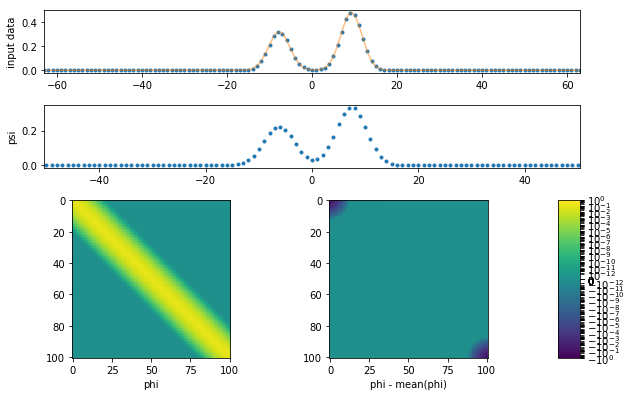

In [18]:
scaled.plot("Scaled")

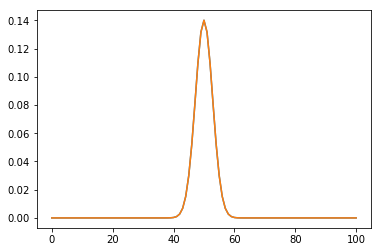

In [24]:
a = aligned.project()
s = scaled.project()
pyplot.figure()
pyplot.plot(a.phi[50,:])
pyplot.plot(s.phi[50,:]/0.8)

In [15]:
scaled.psf.gaussian

Gaussian(scaling=2.5, offset=0.0, flux=1.0)

In [16]:
aligned.psf.gaussian

Gaussian(scaling=2.0, offset=0.0, flux=1.0)

array([[ 0.08968884,  0.10057414,  0.09405345, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.10057414,  0.12036852,  0.12176491, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.09405345,  0.12176491,  0.1350052 , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.1350052 ,
         0.12176491,  0.09405345],
       [ 0.        ,  0.        ,  0.        , ...,  0.12176491,
         0.12036852,  0.10057414],
       [ 0.        ,  0.        ,  0.        , ...,  0.09405345,
         0.10057414,  0.08968884]])

array([[ 0.08020174,  0.08669579,  0.07882485, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08669579,  0.10087919,  0.10003505, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.07882485,  0.10003505,  0.10949957, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.10949957,
         0.10003505,  0.07882485],
       [ 0.        ,  0.        ,  0.        , ...,  0.10003505,
         0.10087919,  0.08669579],
       [ 0.        ,  0.        ,  0.        , ...,  0.07882485,
         0.08669579,  0.08020174]])